## Our basic nlp pipeline
    1) Stem
    2) Add stop words
    3) Tokenize
    4) Vectorize (probably just embedding)

In [1]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/deniska/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
def stem_text(sentence, stopwords=[None]):
    return " ".join([stemmer.stem(word.decode("utf-8")) for word in sentence.split(" ")
                       if word.decode("utf-8") not in stopwords])

In [13]:
# our data
data = pd.read_csv("X_train.csv")

#out stemmer
stemmer = nltk.stem.snowball.RussianStemmer(ignore_stopwords=True)  

#our tokenizer
tokenizer = nltk.tokenize.WordPunctTokenizer()

#preprocess data
data.comment = data.comment.apply(stem_text)
data.reting = data.reting.apply(np.round)

comments = data.comment.as_matrix()
ratings = data.reting.as_matrix().round()

In [4]:
enumerated_text = enumerate(set([0] + tokenizer.tokenize(" ".join(comments))))
word2token = {w : t for t, w in enumerated_text}
token2word = {t : w for w, t in word2token.iteritems()}

In [5]:
def tokenize_sentence(sentence):
    sentence = np.asarray([word2token[word] for word in tokenizer.tokenize(sentence)])
    return sentence
    
def onehot(y, n_class=5):
    Y = np.zeros((len(y), n_class))
    Y[np.arange(len(y)), y] = 1
    return Y

def sample_batch(batch_size):
    ixes = np.random.choice(range(len(comments)), batch_size, False)
    x_batch = np.array([tokenize_sentence(comments[i]) for i in ixes])
    y_batch = np.array([ratings[i] for i in ixes]).astype("int32")
    maxlen = len(max(x_batch, key=len))
    
    return np.array([np.pad(sen, (0, maxlen - len(sen)), "constant", constant_values=(0)) for sen in x_batch]), \
            onehot(y_batch - 1)

In [6]:
VOCAB_SIZE = len(word2token.keys())

In [7]:
%env THEANO_FLAGS=device=gpu0,floatX=float32

import theano
import theano.tensor as T

import lasagne
from lasagne.layers import *

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29



env: THEANO_FLAGS=device=gpu0,floatX=float32


Using gpu device 0: GeForce GTX 1060 6GB (CNMeM is disabled, cuDNN not available)


In [8]:
inputSentence = T.matrix("Sentancia", "int32")
inputClass = T.matrix("Rating", "float32")

In [9]:
net = InputLayer((None, None), inputSentence)
net = EmbeddingLayer(net, VOCAB_SIZE, 128)

net = LSTMLayer(net, 256, grad_clipping=100)
net = LSTMLayer(net, 256, grad_clipping=100, only_return_final=True)

net = DenseLayer(net, 128)
net = DenseLayer(net, 5, nonlinearity=T.nnet.softmax)

In [10]:
output = get_output(net)
loss = lasagne.objectives.categorical_crossentropy(output, inputClass).mean()

In [11]:
params = get_all_params(net, trainable=True)
updates = lasagne.updates.adam(loss, params)
train_fun = theano.function([inputSentence, inputClass], loss, updates=updates, allow_input_downcast=True)

2800


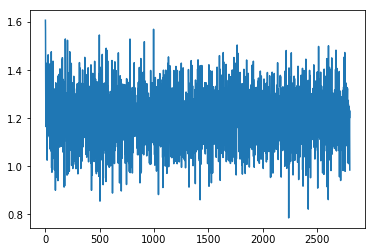

KeyboardInterrupt: 

In [14]:
#training loop

loss = list()
num_epochs = 200000
batch_size = 64
display_epoch = 200

for ep in range(num_epochs):
    x, y = sample_batch(batch_size)
    
    loss.append(train_fun(x, y))
    
    if ep % display_epoch == 0:
        clear_output()
        clear_output()
        print ep
        plt.plot(loss)
        plt.show()


In [ ]:
x, y = sample_batch(64)
print x.shape
print y.shape